In [546]:
import numpy as np
from copy import deepcopy
from PIL import Image
from IPython.display import display, clear_output
import random

In [547]:
# Additional helper functions
def load_image(path):
    # Convert original image to numpy array
    img = Image.open(path).convert("RGB")  # For color images
    return np.array(img)

def downscale_to_original_size(upscaled_array, original_shape):
    # Convert the upscaled image array back into an image
    pil_image = Image.fromarray(upscaled_array)
    # Resize it back to the original size using bicubic interpolation with the pillow library
    downscaled = pil_image.resize(
        (original_shape[1], original_shape[0]),
        Image.BICUBIC
    )
    # Return downscaled image as numpy array
    return np.array(downscaled)

def mse_cost(original_array, reconstructed_array):
    # Calculate mean squared error between the original image array
    return np.square(np.subtract(original_array.astype(float), reconstructed_array.astype(float))).mean()


In [548]:
# Cost function
def downscaler_cost_function(upscaled_array):
    # Downscale the upsacled image and calculate MSE as cost
    reconstructed = downscale_to_original_size(upscaled_array, original_array.shape)
    return mse_cost(original_array, reconstructed)

In [549]:
class problem:
    def __init__(self, original_array):
        self.original_array = original_array
        self.min_value = 0
        self.max_value = 255
        self.acceptable_cost = 10.0
        self.cost_function = downscaler_cost_function


In [550]:
def upscale_image(image_array, scale_factor=2):
    original_height, original_width = image_array.shape[:2]
    new_height = original_height * scale_factor
    new_width = original_width * scale_factor

    # Create upscaled image with random pixel values of upscaled height and width, and colour channels of original image, dtype uint8 (0-255)
    # upscaled = np.random.randint(
    #     0, 256,
    #     size=(new_height, new_width, image_array.shape[2]),
    #     dtype=np.uint8
    # )

    # Get median pixel value of original image array
    median_pixel_value = np.median(image_array)
    # Create upscaled image array of median pixel values
    upscaled = np.full((new_height, new_width, image_array.shape[2]), median_pixel_value, dtype=np.uint8)

    # Assign every scale-factor-th pixel to the original image pixel value
    upscaled[::scale_factor, ::scale_factor] = image_array
    return upscaled


In [551]:
class individual:
    def __init__(self, prob, scale_factor):
        self.chromosome = upscale_image(prob.original_array, scale_factor)
        self.cost = prob.cost_function(self.chromosome)

    def mutate(self, mutation_rate, mutation_range, scale_factor):
        # Create an array of 'true' bool values of size chromosome.
        original_pixel_mask = np.ones(self.chromosome.shape[:2], dtype=bool)
        # Change every scale-factor-th bool value to false (original pixels)
        original_pixel_mask[::scale_factor, ::scale_factor] = False

        # Create an array bool values of size chromosome. Random.rand to generate array values between 0 and 1 uniformly. If value < mutation rate, true. otherwise false
        mutation_mask = np.random.rand(*self.chromosome.shape[:2]) < mutation_rate

        # Combine original pixel mask and mutation mask. Where both are true, they are left true, anything else is set to false.
        mutation_mask = original_pixel_mask & mutation_mask

        # Create 2d array of mutation values of size chromosome, from -mutation range to mutation range + 1.
        mutations = np.random.randint(-mutation_range, mutation_range + 1, self.chromosome.shape, dtype=np.int32)

        # Convert chromosome to integer to allow for adding mutation
        chromosome_int = self.chromosome.astype(np.int32)
        mutation_indices = np.where(mutation_mask)
        chromosome_int[mutation_indices] += mutations[mutation_indices]

        # Clip values between 0-255 and convert to uint8
        self.chromosome = np.clip(chromosome_int, 0, 255).astype(np.uint8)


    def crossover(self, parent2, explore_crossover, scale_factor):
        alpha = np.random.uniform(-explore_crossover, 1 + explore_crossover)
        child1 = deepcopy(self)
        child2 = deepcopy(parent2)

        # Same logic as mutation
        original_pixel_mask = np.ones(self.chromosome.shape[:2], dtype=bool)
        original_pixel_mask[::scale_factor, ::scale_factor] = False

        # Create children chromosomes (unmasked. original pixel values affected)
        child1chromosome = alpha * self.chromosome + (1 - alpha) * parent2.chromosome
        child2chromosome = alpha * parent2.chromosome + (1 - alpha) * self.chromosome

        # Create new chromosomes with original pixel values masked
        child1.chromosome[original_pixel_mask] = child1chromosome[original_pixel_mask]
        child2.chromosome[original_pixel_mask] = child2chromosome[original_pixel_mask]

        # Ensure values are between 0-255 and as dtype uint8
        child1.chromosome = np.clip(child1.chromosome, 0, 255).astype(np.uint8)
        child2.chromosome = np.clip(child2.chromosome, 0, 255).astype(np.uint8)

        return child1, child2

In [552]:
class parameters:
    def __init__(self):
        self.upscale_factor = 2 # Number of pixels to be inserted between each original
        self.population_size = 100
        self.birth_rate_per_generation = 1
        self.rate_of_gene_mutation = 0.001 # Chance of pixel being mutated
        self.range_of_gene_mutation = 5 # Range of pixel value mutation offset
        self.explore_crossover = 0.001
        self.max_number_of_generations = 10000
        self.tournament_size = 5


In [553]:
def tournament_selection(population, tournament_size=5):
    # Choose random individuals from population
    tournament = random.sample(population, tournament_size)
    # Order by cost ascending
    tournament.sort(key=lambda x: x.cost)
    # Return tournament winner, individual with the lowest cost in selection
    return tournament[0]

In [554]:
def choose_parents(population, tournament_size=5):
    parent1 = tournament_selection(population, tournament_size)
    parent2 = tournament_selection(population, tournament_size)

    # Redo tournament if parents are the same
    while parent1 == parent2:
        parent2 = tournament_selection(population, tournament_size)

    # Return parents
    return parent1, parent2

In [555]:
def run_genetic(prob, params):
    population_size = params.population_size
    number_of_children = population_size * params.birth_rate_per_generation
    mutation_rate = params.rate_of_gene_mutation
    mutation_range = params.range_of_gene_mutation
    explore_crossover = params.explore_crossover
    cost_function = prob.cost_function
    acceptable_cost = prob.acceptable_cost
    scale_factor = params.upscale_factor
    tournament_size = params.tournament_size

    # Create population
    population = []
    best_solution = individual(prob, scale_factor)
    best_solution.cost = np.inf
    for i in range(population_size):
        new_individual = individual(prob, scale_factor)
        if new_individual.cost < best_solution.cost:
            best_solution = deepcopy(new_individual)
        population.append(new_individual)

    # Start loop
    for generation in range(params.max_number_of_generations):
        children = []
        while len(children) < number_of_children:
            # Choose parents
            p1, p2 = choose_parents(population, tournament_size)
            # Create children
            c1, c2 = p1.crossover(p2, explore_crossover, scale_factor)
            c1.mutate(mutation_rate, mutation_range, scale_factor)
            c2.mutate(mutation_rate, mutation_range, scale_factor)
            c1.cost = cost_function(c1.chromosome)
            c2.cost = cost_function(c2.chromosome)
            children.append(c1)
            children.append(c2)

        population += children

        # Sort population
        population.sort(key=lambda x: x.cost)

        # Cull population
        population = population[:population_size]

        # Check solution
        if population[0].cost < best_solution.cost:
            best_solution = deepcopy(population[0])

            # Display new best image
            # Enable clear output for live image progress effect
            clear_output(wait=True)
            print(f"Generation {generation+1}: Best cost: {best_solution.cost}")
            best_img = Image.fromarray(best_solution.chromosome)
            downscaled_array = downscale_to_original_size(best_solution.chromosome, prob.original_array.shape)
            original = Image.fromarray(prob.original_array)
            down_image = Image.fromarray(downscaled_array)
            display(best_img, down_image, original)

        if best_solution.cost < acceptable_cost:
            print("Accpetable cost reached")
            break

    return population, best_solution, best_solution.cost



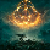

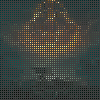

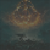

In [556]:
# Test
image_path = "img1.png"
original_array = load_image(image_path)

upscaled_array = upscale_image(original_array, 2)
downscaled_array = downscale_to_original_size(upscaled_array, original_array.shape)

original = Image.fromarray(original_array)
up = Image.fromarray(upscaled_array)
down = Image.fromarray(downscaled_array)
display(original)
display(up)
display(down)

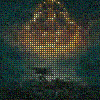

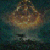

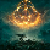

Final best cost: 1168.7902666666666


In [557]:
image_path = "img1.png"
original_array = load_image(image_path)

# Create problem and set parameters
params = parameters()
params.upscale_factor = 2
params.population_size = 50
params.birth_rate_per_generation = 1
params.rate_of_gene_mutation = 0.001
params.range_of_gene_mutation = 10
params.explore_crossover = 0.1
params.max_number_of_generations = 25000
params.tournament_size = 5
prob = problem(original_array)

# Run genetic algorithm
pop, best, best_cost = run_genetic(prob, params)
print("Final best cost:", best_cost)